In [8]:
%matplotlib inline
from _bernstein.lib import bernstein
from nltk.corpus import reuters
import numpy as np
from pprint import pprint
from keras import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.losses import categorical_crossentropy, binary_crossentropy
from keras.optimizers import Adam
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from nltk.corpus import stopwords
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
stop_words = set(stopwords.words('english'))
from tqdm import tqdm
from progressbar import ProgressBar
import pandas as pd
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import seaborn as sbn

In [9]:
import logging
logging.basicConfig(level=logging.DEBUG)

In [12]:
documents = reuters.fileids()

# Problem definition

The goal is to solve a multi label classification problem. I'll be using the reuters corpus to try different techniques. The corpus is available through nltk.

# Exploratory analysis

In [13]:
training_df = pd.DataFrame([(file,len(reuters.categories(file))) for file in documents if file.startswith("training")],columns=["fileid","categories"])
testing_df = pd.DataFrame([(file,len(reuters.categories(file))) for file in documents if file.startswith("test")],columns=["fileid","categories"])

In [40]:
training_df.describe()

,categories
count,7769.000000
mean,1.233621
std,0.713719
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,15.000000


In [42]:
testing_df.describe()

,categories
count,3019.000000
mean,1.240146
std,0.823949
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,14.000000


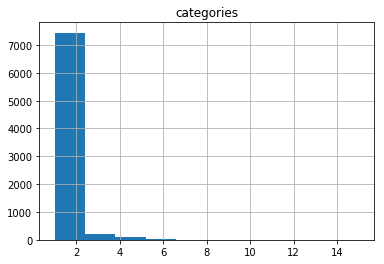

In [46]:
training_df.hist();

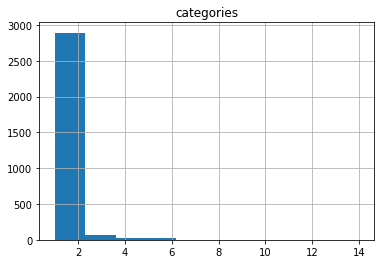

In [45]:
testing_df.hist();

Both sets seem equally balanced

# Pipeline prep

In [18]:
X, X_test = [], []
y, y_test = [], []

mlb = MultiLabelBinarizer()
mlb.fit([[cat] for cat in reuters.categories()])

for file in documents:
    x_ = X_test if file.startswith("test") else X
    y_ = y_test if file.startswith("test") else y
    x_.append(" ".join(reuters.words(file)))
    y_.append(reuters.categories(file))

X, X_ = np.array(X), np.array(X_test)

# Naive Bayes

In [19]:
NBPipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
    ('clf', OneVsRestClassifier(BernoulliNB(fit_prior=True, class_prior=None))),
])

NBPipeline.fit(X,mlb.transform(y))
predictions = NBPipeline.predict(X_test)
print("NBPipeline accuracy: {}".format(accuracy_score(mlb.transform(y_test),predictions)))

NBPipeline accuracy: 0.5240145743623716


# Random Forests

In [20]:
RFPipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
    ('clf', RandomForestClassifier(n_estimators=50,n_jobs=-1,random_state=111)),
])

RFPipeline.fit(X,mlb.transform(y))
predictions = RFPipeline.predict(X_test)
print("RFPipeline accuracy: {}".format(accuracy_score(mlb.transform(y_test),predictions)))

RFPipeline accuracy: 0.6538588936734018


# Hashing trick + NN

I needed a multilevel hashing function. Instead of searching for a python implementation, I used cffi wrap around some old C code i had laying around to make an extension module. I used Dan Bernstein's hash function.

In [17]:
TABLES = 4
BUCKETS = 1000

logging.info("Starting with {} tables and {} buckets".format(TABLES,BUCKETS))

X_train = {}
y_train = {}

X_test = {}
y_test = {}

categories_ohe = {v:i for i,v in enumerate(reuters.categories())}
logging.info("One Hot Encoding dict generated")
categories_len = len(reuters.categories())
logging.info("{} categories found".format(categories_len))

with ProgressBar(max_value=len(documents)) as pbar:
    for index, file in enumerate(documents):
        xdict = X_test if file.startswith("test") else X_train
        ydict = y_test if file.startswith("test") else y_train
        minhashes = np.zeros((TABLES,BUCKETS))
        for i in range(TABLES):
            minhash = minhashes[i]
            for word in reuters.words(file):
                minhash[bernstein(bytes(word.encode('UTF8')),i,BUCKETS)]+=1
        xdict[file] = minhashes
        y_value = np.zeros(categories_len)
        for cat in reuters.categories(file):
            y_value[categories_ohe[cat]] = 1
        ydict[file] = y_value
        pbar.update(index)

logging.info("All training vectors generated")

X, X_ = [], []
y, y_ = [], []

for key in X_train.keys():
    X.append(X_train[key])
    y.append(y_train[key])

for key in X_test.keys():
    X_.append(X_test[key])
    y_.append(y_test[key])

X, X_ = np.array(X), np.array(X_)
y, y_ = np.array(y), np.array(y_)

logging.info("{} training instances".format(len(X)))
logging.info("{} test instances".format(len(X_)))

INFO:root:Starting with 4 tables and 1000 buckets
INFO:root:One Hot Encoding dict generated
INFO:root:90 categories found
100% (10788 of 10788) |##################| Elapsed Time: 0:00:29 Time:  0:00:29
INFO:root:All training vectors generated
INFO:root:7769 training instances
INFO:root:3019 test instances


In [18]:
model = Sequential()
model.add(Flatten(input_shape=(TABLES,BUCKETS)))
model.add(Dense(BUCKETS,activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(500,activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(categories_len,activation='sigmoid'))
model.compile(loss=binary_crossentropy,optimizer=Adam(),metrics=['accuracy'])

In [19]:
#SVG(model_to_dot(model).create(prog='dot', format='svg'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 4000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              4001000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 500)               500500    
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 90)                45090     
Total params: 4,546,590
Trainable params: 4,546,590
Non-trainable params: 0
_________________________________________________________________


In [20]:
logging.info("Training model")
model.fit(X,y,batch_size=50,epochs=10,verbose=2,validation_data=(X_,y_))
score = model.evaluate(X_, y_, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

INFO:root:Training model


Train on 7769 samples, validate on 3019 samples
Epoch 1/10
 - 18s - loss: 0.0640 - acc: 0.9862 - val_loss: 0.0251 - val_acc: 0.9946
Epoch 2/10
 - 18s - loss: 0.0169 - acc: 0.9957 - val_loss: 0.0209 - val_acc: 0.9949
Epoch 3/10
 - 16s - loss: 0.0102 - acc: 0.9971 - val_loss: 0.0199 - val_acc: 0.9955
Epoch 4/10
 - 19s - loss: 0.0065 - acc: 0.9980 - val_loss: 0.0201 - val_acc: 0.9955
Epoch 5/10
 - 17s - loss: 0.0049 - acc: 0.9985 - val_loss: 0.0201 - val_acc: 0.9959
Epoch 6/10
 - 16s - loss: 0.0039 - acc: 0.9988 - val_loss: 0.0204 - val_acc: 0.9955
Epoch 7/10
 - 19s - loss: 0.0032 - acc: 0.9990 - val_loss: 0.0225 - val_acc: 0.9956
Epoch 8/10
 - 19s - loss: 0.0029 - acc: 0.9992 - val_loss: 0.0214 - val_acc: 0.9957
Epoch 9/10
 - 20s - loss: 0.0030 - acc: 0.9992 - val_loss: 0.0212 - val_acc: 0.9958
Epoch 10/10
 - 20s - loss: 0.0031 - acc: 0.9992 - val_loss: 0.0241 - val_acc: 0.9955
('Test loss:', 0.02405112795315809)
('Test accuracy:', 0.9955172606278982)
